In [1]:
import sys
sys.path.append("D:\python\lib\site-packages")
import pyxdf as xdf
import numpy as np
import matplotlib.pyplot as plt
import mne
%matplotlib notebook

### Load your data from the .xdf file

In [ ]:
# Load file
yoshe_xdf = "yoshe_test.xdf"
annach_xdf = "annachess_test.xdf"
annag_xdf = "annag_test.xdf"

current_xdf = yoshe_xdf

streams = xdf.load_xdf(current_xdf)

# Extract streams
unitystr_time_series     = streams[0][0]['time_series']
unitystr_time_stamps     = streams[0][0]['time_stamps']
unitystr_first_timestamp = np.float(unitystr_time_stamps[0])#np.float(streams[0][0]['footer']['info']['first_timestamp'][2])

openvibemarkers_time_series     = streams[0][1]['time_series']
openvibemarkers_time_stamps     = streams[0][1]['time_stamps']
openvibemarkers_first_timestamp = np.float(streams[0][1]['footer']['info']['first_timestamp'][0])

eeg_time_series     = streams[0][2]['time_series']
eeg_time_stamps     = streams[0][2]['time_stamps']
eeg_first_timestamp = np.float(streams[0][2]['footer']['info']['first_timestamp'][0])

# Sampling frequency of the recorded eeg data
sfreq = np.float(streams[0][2]['info']['nominal_srate'][0])

In [ ]:
xdf.load_xdf(yoshe_xdf)

In [ ]:
#Convert labels to codes: 1-chose high, 2-chose low, 3- Reward high, 4-reward low, 5-no reward

for i in range (len(unitystr_time_series)):
    if "PressedHigh" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=1
    elif "PressedLow" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=2
    elif "RewardHigh" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=3
    elif "RewardLow" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=4
    elif "RewardNone" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=5
        

In [ ]:
print(unitystr_time_series)
len(unitystr_time_series)

In [ ]:
print(unitystr_time_stamps)
len(unitystr_time_stamps) #[AS comment]as you can see below and directly in the xdf file above unity timestamps end around 687 and eeg itmestamps around 600. I checked a CSV file made using Hector's script and there in . the result of his find_nearest function I guess we lost all markers after 39th trial. Looks like our synchronisation process has some flow=(

In [ ]:
print(eeg_time_stamps)
len(eeg_time_stamps)
print(eeg_time_stamps[0])

In [ ]:
#Code to cleanup and trim the mismatching unity timestamps

for i in range (len(unitystr_time_stamps)):
    if unitystr_time_stamps[i] < eeg_time_stamps[0]:
        unitystr_time_stamps[i] = 0
        unitystr_time_series[i] = 0
    if unitystr_time_stamps[i] > eeg_time_stamps[-1]:
        unitystr_time_stamps[i] = 0
        unitystr_time_series[i] = 0

C_unitystr_time_stamps = np.trim_zeros(unitystr_time_stamps)
C_unitystr_time_series = np.trim_zeros(unitystr_time_series)

print(C_unitystr_time_stamps)
print(C_unitystr_time_series)

### Create a RAW array object to store the EEG data

In [ ]:
# 14 channels: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4

ch_names = ('AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4')

# Create the info file
info = mne.create_info(ch_names, sfreq, ch_types='eeg' )

# Convert first time to sample
first_samp = int(eeg_first_timestamp*sfreq)
print(first_samp)

In [ ]:
# NB set the first sample to be able to align the events
raw = mne.io.RawArray(eeg_time_series.T, info, first_samp=first_samp)

# raw.set_eeg_reference()

### Set montage

In [ ]:
montage = mne.channels.read_montage('standard_1020')

raw.set_montage(montage)
f = raw.plot_sensors(ch_type='eeg', title=['EMOTIV EEG'], show_names=True, ch_groups='position', show=False)
f.set_size_inches(4,4)

In [ ]:
# Plot some data
raw.plot(scalings='auto', n_channels=14, show=False);

raw.plot_psd(fmin=2.0, fmax=40.0, show=False);

### Define the event channel

In [ ]:
# Create a ne stimulation channels
info         = mne.create_info(['STI'], raw.info['sfreq'], ch_types=['stim'])
# Fill it with an vector of zeros
stim_data    = np.zeros((1, len(raw.times)))

In [ ]:
stim_raw     = mne.io.RawArray(stim_data, info, first_samp=first_samp)

In [ ]:
# Add the new channel to your dataset
raw.add_channels([stim_raw], force_update_info=False)

In [ ]:
(C_unitystr_time_stamps*sfreq).astype('int')

In [ ]:
# You need to build an array of events
#events = np.array(((openvibemarkers_time_stamps*sfreq).astype('int'), np.zeros((len(openvibemarkers_time_series),)), np.squeeze(openvibemarkers_time_series)))


In [ ]:
# You need to build an array of events
events = np.array(((C_unitystr_time_stamps*sfreq).astype('int'), np.zeros((len(C_unitystr_time_series),)), np.squeeze([C_unitystr_time_series])))


In [ ]:
print(events)

In [ ]:
# Add the openvibe events
raw.add_events(events.T, stim_channel='STI')

In [ ]:
f = raw.plot(scalings='auto', show=False)
f.set_size_inches(8,4)

In [ ]:
### Re-reference your data
raw.set_eeg_reference()

### Epoching data

In [ ]:
## evs should return the same 'events' array you used to create the channel ( I did it just to confirm that all the events are there)


# With the option output='onset' we find only 26 events NB EVENTS ARE VERY CLOSE (JUST 1 TIMESTAMP BETWEEN TWO EVENTS)
# If you set it to 'step' you will have back all the 52 events (but it does not make sense for epoching your data)



evs = mne.find_events(raw, stim_channel='STI', output='onset', shortest_event=1,
                         min_duration=1/raw.info['sfreq'])
print('Number of events found: %d' % len(evs))

In [ ]:
# Pick the channels you want to include 
reject = dict(eeg=150e-6) # you can set a rejection threshold for bad data (NB in this case all data will be discarded)

baseline = (None,None)
picks = mne.pick_types(raw.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude=[])


# Define the beginning and the end of each epoch
tmin = -1.
tmax = 2.5

# Epoch the data around event 1 (here defined as "trial_start")
epochs =  mne.Epochs(raw, evs, tmin=tmin, tmax=tmax, 
                     baseline=baseline, preload=True, reject=None)

# Check if all the epochs (nr of trials in the experiment) were extracted
print('Number of epochs: %d' % len(epochs))

In [ ]:
epochs.events

### QUICK START

Run the code below three times, changing the current_xdf value for the 3 xdf files.

In [9]:
yoshe_xdf = "yoshe_test.xdf"
annach_xdf = "annachess_test.xdf"
annag_xdf = "annag_test.xdf"

current_xdf = yoshe_xdf

streams = xdf.load_xdf(current_xdf)

# Extract streams
unitystr_time_series     = streams[0][0]['time_series']
unitystr_time_stamps     = streams[0][0]['time_stamps']
unitystr_first_timestamp = np.float(unitystr_time_stamps[0])#np.float(streams[0][0]['footer']['info']['first_timestamp'][2])

openvibemarkers_time_series     = streams[0][1]['time_series']
openvibemarkers_time_stamps     = streams[0][1]['time_stamps']
openvibemarkers_first_timestamp = np.float(streams[0][1]['footer']['info']['first_timestamp'][0])

eeg_time_series     = streams[0][2]['time_series']
eeg_time_stamps     = streams[0][2]['time_stamps']
eeg_first_timestamp = np.float(streams[0][2]['footer']['info']['first_timestamp'][0])

# Sampling frequency of the recorded eeg data
sfreq = np.float(streams[0][2]['info']['nominal_srate'][0])

#Convert labels to codes: 1-chose high, 2-chose low, 3- Reward high, 4-reward low, 5-no reward

for i in range (len(unitystr_time_series)):
    if "PressedHigh" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=1
    elif "PressedLow" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=2
    elif "RewardHigh" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=3
    elif "RewardLow" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=4
    elif "RewardNone" in str(unitystr_time_series[i]):
        unitystr_time_series[i]=5

#Code to cleanup and trim the mismatching unity timestamps

for i in range (len(unitystr_time_stamps)):
    if unitystr_time_stamps[i] < eeg_time_stamps[0]:
        unitystr_time_stamps[i] = 0
        unitystr_time_series[i] = 0
    if unitystr_time_stamps[i] > eeg_time_stamps[-1]:
        unitystr_time_stamps[i] = 0
        unitystr_time_series[i] = 0

C_unitystr_time_stamps = np.trim_zeros(unitystr_time_stamps)
C_unitystr_time_series = np.trim_zeros(unitystr_time_series)

# 14 channels: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4

ch_names = ('AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4')

# Create the info file
info = mne.create_info(ch_names, sfreq, ch_types='eeg' )

# Convert first time to sample
first_samp = int(eeg_first_timestamp*sfreq)

# NB set the first sample to be able to align the events
raw = mne.io.RawArray(eeg_time_series.T, info, first_samp=first_samp)

#filter the raw
print("RAW:", raw)
#raw = raw.filter(1., 50., fir_design='firwin')
print("RAW2:",raw)

montage = mne.channels.read_montage('standard_1020')

raw.set_montage(montage)

# Create a ne stimulation channels
info         = mne.create_info(['STI'], raw.info['sfreq'], ch_types=['stim'])
# Fill it with an vector of zeros
stim_data    = np.zeros((1, len(raw.times)))

stim_raw     = mne.io.RawArray(stim_data, info, first_samp=first_samp)

# Add the new channel to your dataset
raw.add_channels([stim_raw], force_update_info=False)

(C_unitystr_time_stamps*sfreq).astype('int')

# You need to build an array of events
events = np.array(((C_unitystr_time_stamps*sfreq).astype('int'), np.zeros((len(C_unitystr_time_series),)), np.squeeze([C_unitystr_time_series])))

# Add the openvibe events
raw.add_events(events.T, stim_channel='STI')

### Re-reference your data
raw.set_eeg_reference()

## evs should return the same 'events' array you used to create the channel ( I did it just to confirm that all the events are there)


# With the option output='onset' we find only 26 events NB EVENTS ARE VERY CLOSE (JUST 1 TIMESTAMP BETWEEN TWO EVENTS)
# If you set it to 'step' you will have back all the 52 events (but it does not make sense for epoching your data)



evs = mne.find_events(raw, stim_channel='STI', output='onset', shortest_event=1,
                         min_duration=1/raw.info['sfreq'])
print('Number of events found: %d' % len(evs))

# Pick the channels you want to include 
reject = dict(eeg=150e-6) # you can set a rejection threshold for bad data (NB in this case all data will be discarded)

baseline = (None,None)
picks = mne.pick_types(raw.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude=[])


# Define the beginning and the end of each epoch
tmin = -1.
tmax = 1

# Epoch the data around event 1 (here defined as "trial_start")
epochs =  mne.Epochs(raw, evs, tmin=tmin, tmax=tmax, 
                     baseline=baseline, preload=True, reject=None)

# Check if all the epochs (nr of trials in the experiment) were extracted
print('Number of epochs: %d' % len(epochs))

if current_xdf == yoshe_xdf:
    epochs_yoshe = epochs
    raw_yoshe = raw
if current_xdf == annach_xdf:
    epochs_annach = epochs
    raw_annach = raw
if current_xdf == annag_xdf:
    epochs_annag = epochs
    raw_annag = raw

print("")    
print("----------------")    
print(epochs_yoshe, raw_yoshe)
print("----------------")
print(epochs_annach, raw_annach)
print("----------------")
print(epochs_annag, raw_annag)

Creating RawArray with float64 data, n_channels=14, n_times=57256
    Range : 19664 ... 76919 =    153.625 ...   600.930 secs
Ready.
RAW: <RawArray  |  None, n_channels x n_times : 14 x 57256 (447.3 sec), ~6.1 MB, data loaded>
RAW2: <RawArray  |  None, n_channels x n_times : 14 x 57256 (447.3 sec), ~6.1 MB, data loaded>
Creating RawArray with float64 data, n_channels=1, n_times=57256
    Range : 19664 ... 76919 =    153.625 ...   600.930 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
77 events found
Event IDs: [1 2 3 5]
Number of events found: 77
77 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 77 events and 257 original time points ...
0 bad epochs dropped
Number of epochs: 77

----------------
<Epochs  |   77 events (all good), -1 - 1 sec, baseline [None, None], ~2.3 MB, data loaded,
 '1': 37
 '2': 2
 '3': 22
 '5': 16> <RawArray  |  None, n_channels x n_times : 15 x 57256 (4

In [ ]:
#Plotting the raw
raw = raw_annag

#raw.plot(scalings='auto', n_channels=14, show=False);
#raw.plot_psd(fmin=2.0, fmax=40.0, show=False);
raw.plot_psd(fmin=2.0, fmax=45.0, area_mode='range', tmax=10.0, picks=picks, average=False)

#notch filter
#raw = raw.notch_filter(np.arange(60, 100, 60), picks=picks, fir_design='firwin')
#raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)
#raw.plot_psd(fmin=2.0, fmax=40.0, show=False);

# low pass filtering below 50 Hz
raw = raw.filter(1., 50., fir_design='firwin')

raw.plot_psd(fmin=2.0, fmax=45.0, area_mode='range', tmax=10.0, picks=picks, average=False)


In [10]:
epochs_all = mne.concatenate_epochs([epochs_yoshe, epochs_annach, epochs_annag])
raw_all = mne.concatenate_raws([raw_yoshe, raw_annach, raw_annag])
print(epochs_all, raw_all)

273 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 bad epochs dropped
<Epochs  |   273 events (all good), -1 - 1 sec, baseline [None, None], ~8.1 MB, data loaded,
 '1': 103
 '2': 34
 '3': 51
 '4': 17
 '5': 68> <RawArray  |  None, n_channels x n_times : 15 x 162044 (1266.0 sec), ~18.6 MB, data loaded>


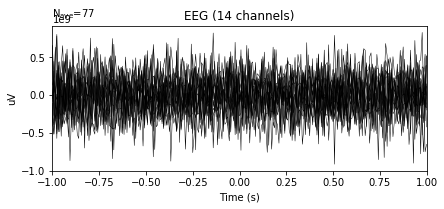

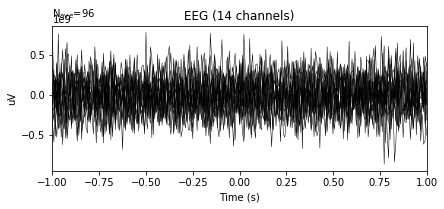

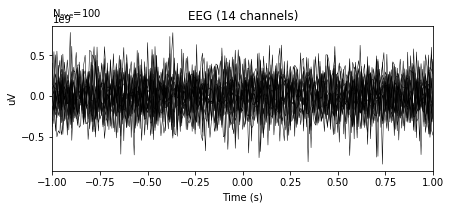

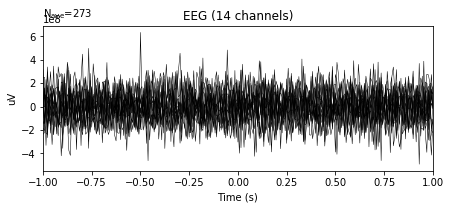

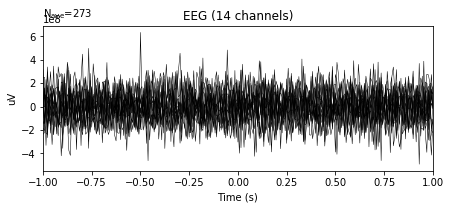

In [14]:
evoked_1 = epochs_yoshe.average()
evoked_2 = epochs_annach.average()
evoked_3 = epochs_annag.average()
evoked_all = epochs_all.average()
evoked_1.plot(time_unit='s')
evoked_2.plot(time_unit='s')
evoked_3.plot(time_unit='s')
evoked_all.plot(time_unit='s')

mne extract power; take windows of 100ms and average the values of these (windowlength and overlapping of the time windows is up to us)or 500ms and moving of 200, etc normally overlapping is 80%. it will be a vector of all the freq values of this timeframe and those can be fed to the network. he suggests recurrent network. make it parametric so we can modify variables. important to put labels

In [ ]:
from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate

this_epoch = epochs_annag
raw = raw_annag

epochs_train = this_epoch.copy()
labels = this_epoch.events[:, -1]


# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = this_epoch.get_data()
epochs_data_train = epochs_train.get_data()


#cv = ShuffleSplit(10, test_size=0.2, random_state=42)
#cv_split = cv.split(epochs_data_train)
# Generate 10 folds for cross-validation using 20% of data as test set
cv = ShuffleSplit(10, test_size=.2, random_state=42)
cv_split = cv.split(epochs_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp = CSP(n_components=4, reg='ledoit_wolf', log=None, cov_est='epoch', norm_trace=False)

#for i in epochs_data_train:
    #print(i.shape)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(this_epoch.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)


In [ ]:
layout = read_layout('EEG1005')
csp.plot_patterns(this_epoch.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

In [ ]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + this_epoch.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()